# Airport traffic

Can we estimate global airport traffic?

## Airports around the world


In [1]:
import pandas as pd
#from https://openflights.org/
airport_file = "./data/airports/airports.dat"
columns=['ID','Name','City','Country','IATA','ICAO',
         'Latitude','Longitude','Altitude','Timezone','DST','tz','Type','Source']
airports = pd.read_csv(airport_file,header=None)
airports.columns=columns
airports.head(2)


,ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,tz,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports


## Routes around the world


In [2]:
#from http://arm.64hosts.com/ FROM 2020
routes_file = "./data/airports/AirlineRouteMapper/routes.dat"
routes = pd.read_csv(routes_file,sep='\t',skiprows=[1])
print(len(routes))
routes.head(2)

33580


,# airline,from,to,codeshare,stops,equipment
0,#C7,MAO,CIZ,NaN,0,EMB
1,0B,BCM,BGY,NaN,0,735


In [3]:
routes_file = "./data/airports/routes.dat"
columns=['Airline','Airline_ID',
         'Source_IATA','Source_id',
         'Destination_IATA','Destination_id',
         'Codeshare','Stops','Equipment']
routes = pd.read_csv(routes_file,header=None)
routes.columns=columns
keep_cols=['Source_IATA','Destination_IATA','Equipment']
routes=routes[keep_cols]
print(len(routes))
routes.head(2)

67663


,Source_IATA,Destination_IATA,Equipment
0,AER,KZN,CR2
1,ASF,KZN,CR2


In [4]:
#TOP DESTINATIONS
routes.groupby('Source_IATA').count().sort_values(by='Destination_IATA',ascending=False)['Destination_IATA'].head(5)

Source_IATA
ATL    915
ORD    558
PEK    535
LHR    527
CDG    524
Name: Destination_IATA, dtype: int64

In [5]:
#TOP SOURCES
routes.groupby('Destination_IATA').count().sort_values(by='Source_IATA',ascending=False)['Source_IATA'].head(5)

Destination_IATA
ATL    911
ORD    550
PEK    534
LHR    524
CDG    517
Name: Source_IATA, dtype: int64

## Add lat lons to routes

In [6]:
cols=['IATA','Latitude','Longitude']

for x in ['Source','Destination']:
        routes=pd.merge(routes, airports[cols], how='inner', 
                        left_on='%s_IATA'%x, right_on='IATA').rename(
            columns={'Latitude': '%s_Latitude'%x, 'Longitude': '%s_Longitude'%x}).drop(columns=['IATA'])


In [7]:
print(len(routes))
routes.head(2)

66934


,Source_IATA,Destination_IATA,Equipment,Source_Latitude,Source_Longitude,Destination_Latitude,Destination_Longitude
0,AER,KZN,CR2,43.449902,39.956600,55.606201,49.278702
1,ASF,KZN,CR2,46.283298,48.006302,55.606201,49.278702


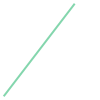

In [36]:
from shapely.geometry import Point, LineString

def get_line(row):
    a = Point( row.Source_Longitude, row.Source_Latitude,)
    b = Point( row.Destination_Longitude, row.Destination_Latitude)
    line = LineString([a, b]) 
    return line
get_line(routes.loc[0])

In [37]:
import geopandas as gdp
routes['geometry'] = routes.apply(lambda row: get_line(row), axis=1)
routes = gdp.GeoDataFrame(routes,crs="epsg:4327")

In [38]:
routes.head(2).to_crs("epsg:3857")

,Source_IATA,Destination_IATA,Equipment,Source_Latitude,Source_Longitude,Destination_Latitude,Destination_Longitude,geometry
0,AER,KZN,CR2,43.449902,39.956600,55.606201,49.278702,"LINESTRING (4447948.366 5380704.176, 5485679.9..."
1,ASF,KZN,CR2,46.283298,48.006302,55.606201,49.278702,"LINESTRING (5344037.080 5825864.811, 5485679.9..."


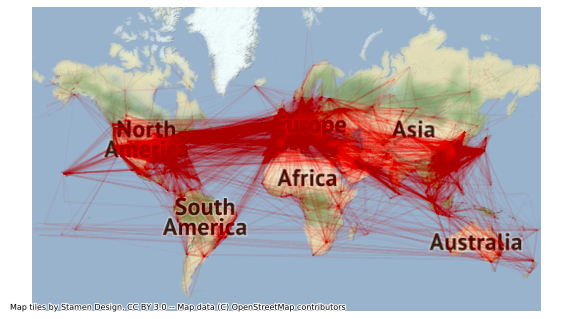

In [44]:
import contextily as ctx

ax = routes.to_crs("epsg:3857").plot(figsize=(10, 10), alpha=0.01,color='red')
ctx.add_basemap(ax,zoom=1)
ax.set_axis_off()